# Model Dependence on Class Imbalance
In this section we study the susceptibility of usual binary classifications algorithms when
dealing with imbalanced datasets (cf. definition of imabalanced dataset somewhere).
The exploration of the model/imbalance rate interaction is carried out, in principle, via the impact of imbalance on classification metrics of the typical classification models used in the literature and the industry.

# Imports

In [64]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any, List, Dict

# plotting
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt

# sklearn
from sklearn.datasets import make_classification


# Data
Synthetic data is generated using sciki-learn functionalities.

In [2]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

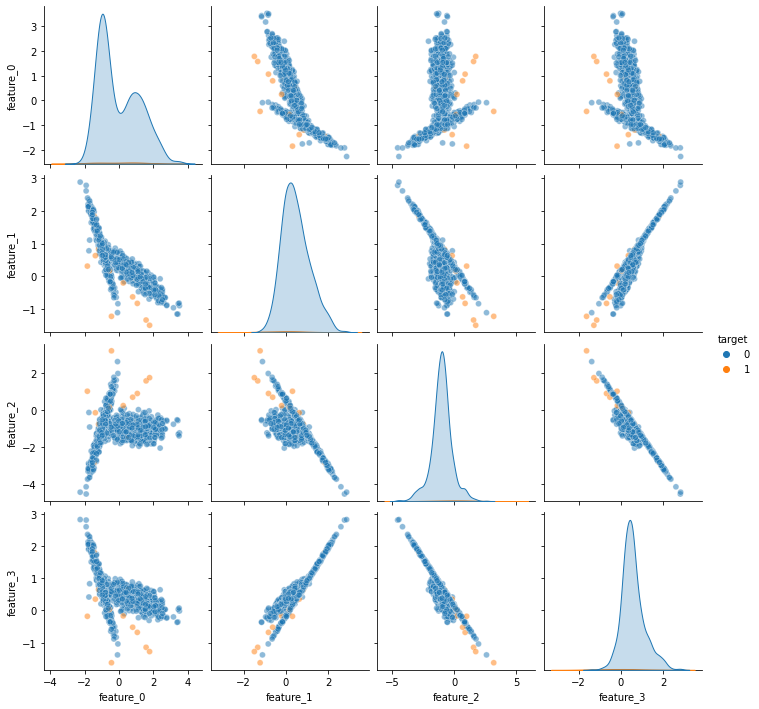

In [3]:
n_samples = 10**3
n_features = 4
imbalance = 0.01
n_informative = 2
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})


# Decision Tree Classifier


In [4]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [5]:
random_state = 42
X, y = data[column_names], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
clf = DecisionTreeClassifier(max_leaf_nodes = 3, random_state = random_state)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)

Let us have a look at the details of the tree 

In [6]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

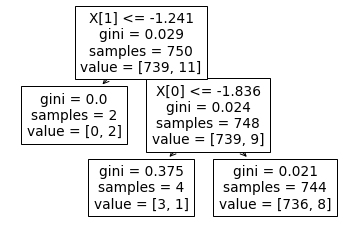

In [7]:
tree.plot_tree(clf)
plt.show()

# Experiment 1: Impact on Performance
We will compare the imbalance impact on the classifier performance. Our benchmark model will be a logistic regression.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve,\
                            average_precision_score, f1_score

## Metrics functions

In [9]:
def bootstrap_samples(y_true: List, y_pred: List, n_batches: int = 100) -> List:
    """Get bootstrap samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    preds_samples : array_like, shape = [n_samples, [n_batches, 2]]
        list of bootstrap samples from y_true and y_preds
    """
    # y_true = pd.Series(y_true, name='y_true')
    # y_pred = pd.Series(y_pred, name='y_pred')
    # df_preds = pd.concat((y_true, y_pred), axis=1)
    df_preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    n_samples = len(y_true)
    preds_samples = []
    for i in np.arange(n_batches):

        df_preds_resample = df_preds.sample(n_samples, replace=True)

        y_true_resample = df_preds_resample['y_true'].values
        y_pred_resample = df_preds_resample['y_pred'].values

        preds_samples.append({'y_true': y_true_resample,
                              'y_pred': y_pred_resample})

    preds_samples = preds_samples

    return preds_samples

In [10]:
def delinquency_curve(y_true, y_score, pointwise=True):
    """ Delinquency curve.

    The delinquency curve is curve that shows the default rate in function of
    the approval rate. With this curve is possible to have a clear view of a
    credit operation and its characteristics for all possible scenarios.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        Correct labels for given dataset.

    y_score : array, shape = [n_samples]
        Predict scores for the given dataset.

    pointwise : bool, optional
        boolean indicating whether to compute pointwise delinquency curve.

    Returns
    -------
    approval_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Array containing the approval rates used to compute the default_rate
        curve.
    default_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Default rate values for the approval rates provided in approval_rate.
        default_rate[i] is the ratio of events registered in the best
        approval_rate[i]% of scores.

    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    assert len(y_true) == len(y_score), F"y_true and y_score doesn't have " \
        F"the same length. len(y_true) = " \
        F"{len(y_true)}, len(y_score) = " \
        F"{len(y_score)}"

    indexsort = np.argsort(y_score)[::-1]
    y_approved = y_true[indexsort].copy()

    if pointwise:
        list_index = np.arange(1, len(y_approved)+1)
        approval_rate = np.append(0, list_index/len(list_index))
        default_rate = np.append(0, y_approved.cumsum()/list_index)
    else:
        approval_rate = np.linspace(0, 1, 21)
        n = len(y_true)

        default_rate = np.array([y_approved[:int(np.floor(i * n))].mean()
                                 if (y_approved[:int(np.floor(i * n))]
                                     .size)
                                 else 0 for i in approval_rate])
    return approval_rate, default_rate

In [11]:
def compute_metrics(y_true: List, y_proba: List, n_round: int = 2) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_round : int, optional
        number o decimals to round gini and ks metrics
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = np.round(roc_auc_score(y_true, y_proba), n_round)
    # GINI
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    # Average precision
    metrics['avg_precision'] = np.round(average_precision_score(y_true, y_proba), n_round)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {'fpr': fpr,
                            'tpr': tpr, 
                            'thresholds': thresholds_roc}
    # Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve'] = {'precision' : precision,
                            'recall': recall,
                            'thresholds': thresholds_pr}
    # Delinquency curve
    d_curve_p = delinquency_curve(y_true = y_true, y_score = 1 - y_proba, pointwise= True)
    d_curve_agg = delinquency_curve(y_true = y_true, y_score = 1 - y_true, pointwise = False)
    metrics['d_curve_pointwise'] = d_curve_p
    metrics['d_curve_agg'] = d_curve_agg

    return metrics


In [12]:
def compute_metrics_bootstrap(y_true, y_pred, n_batches=100):
    """computes frequently used metrics from bootstramp samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    metrics_summary : dict
        dictionary containig statistics of gini, ks, d_curve and c_curves
    """
    preds_samples = bootstrap_samples(y_true, y_pred, n_batches)

    df_metrics = pd.DataFrame([compute_metrics(y['y_true'],
                                                     y['y_pred'])
                              for y in preds_samples])

    approval_rate_p = df_metrics['d_curve_pointwise'].iloc[0][0]
    default_rate_mean_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).mean()
    default_rate_std_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_p = (approval_rate_p, default_rate_mean_p)
    d_curve_std_p = (approval_rate_p, default_rate_std_p)

    approval_rate_agg = df_metrics['d_curve_agg'].iloc[0][0]
    default_rate_mean_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).mean()
    default_rate_std_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_agg = (approval_rate_agg, default_rate_mean_agg)
    d_curve_std_agg = (approval_rate_agg, default_rate_std_agg)

    metrics_stats = df_metrics[['roc_auc',
                                'gini',
                                'avg_precision',
                                # 'ks'
                                ]].apply([np.mean, np.std])

    metrics_summary = {'d_curve_pointwise': {'d_curve_mean': d_curve_mean_p,
                                             'd_curve_std': d_curve_std_p},
                       'd_curve_agg': {'d_curve_mean': d_curve_mean_agg,
                                       'd_curve_std': d_curve_std_agg},
                       'metrics_stats': metrics_stats,
                       'df_metrics': df_metrics}
    return metrics_summary

## Performance vs Imbalance
Let us see how the performance changes for different imbalance ratios:

In [83]:
n_samples = 10**5
n_features = 4
n_informative = 2
metrics = {}
imbalances = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-4]
random_state = 42
for imbalance in imbalances:
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance)
    # Train test split
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression
    print('\tLog Regression ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    # metrics[imbalance]['logreg'] = compute_metrics(y_true = y_test, y_proba = y_proba_lr[:,1])
    metrics[imbalance]['logreg'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Decision Tree
    print('\tDecision Tree ...')
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    y_proba_dt = dt_clf.predict_proba(X_test)
    # metrics[imbalance]['dt'] = compute_metrics(y_true = y_test, y_proba= y_proba_dt[:,1])
    metrics[imbalance]['dt'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dt[:,1])



Minority class proportion: 0.5
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.3
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.2
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.1
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.05
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.01
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.005
	Log Regression ...
	Decision Tree ...
Minority class proportion: 0.0001
	Log Regression ...
	Decision Tree ...


In [71]:
def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

<AxesSubplot:xlabel='Minority class proportion', ylabel='ROC_AUC'>

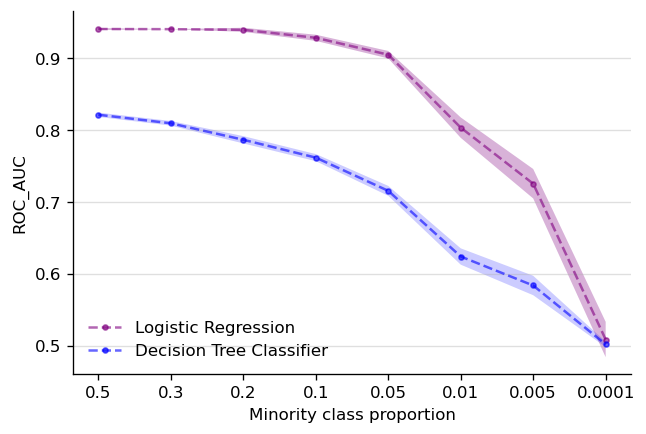

In [84]:
metric_4_display = 'roc_auc'
logreg_metrics = [metrics[x]['logreg']['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
logreg_std = [metrics[x]['logreg']['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
dt_metrics = [metrics[x]['dt']['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
dt_std = [metrics[x]['dt']['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
x = range(len(imbalances))
f, ax = plt.subplots(dpi = 120)
# Logistic Regression
ax.plot(logreg_metrics, marker = '.', linestyle = '--',
            color = 'purple', label = 'Logistic Regression',
            alpha = 0.6)
ax.fill_between(x = x, 
                y1 = np.subtract(logreg_metrics, logreg_std), 
                y2 =np.add(logreg_metrics, logreg_std),
                alpha = 0.3, facecolor = 'purple')
ax.set_xticks(range(len(imbalances)))
ax.set_xticklabels(imbalances)
ax.set_xlabel('Minority class proportion')
# Decision Tree Classifier
ax.plot(dt_metrics, marker = '.', linestyle = '--',
            color = 'blue', label = 'Decision Tree Classifier',
            alpha = 0.6)
ax.fill_between(x = x, 
                y1 = np.subtract(dt_metrics, dt_std), 
                y2 =np.add(dt_metrics, dt_std),
                alpha = 0.2, facecolor = 'blue')
ax.set_ylabel(metric_4_display.upper())
# ax.axhline(y = 0.5, color = 'r', alpha = 0.5, label = 'Random Classifier')
ax.legend(loc = 'best', frameon = False,)
ax.grid(True, axis = 'y', alpha = 0.4)
clean_ax(ax)

In [73]:
def plot_roc_curve(df_metrics: pd.DataFrame,
                    color: str = 'purple',
                    label : str = None, 
                    ax : matplotlib.axis = None) -> matplotlib.axis:
    """plots the roc curve for a bootstrapped confidence interval
    Parameters
    ----------
    df_metrics: pd.DataFrame
        dataframe that holds the roc curves for each boostrap sample
    label: str, (default = None)
    axis: matplotlib.axis (default = None)
    Returns
    -------
    ax: matplotlib.axis
    """
    assert isinstance(df_metrics, pd.DataFrame), 'df_metrics has to be a dataframe object!'
    if ax == None:
        f, ax = plt.subplots(dpi = 120)
    if label == None:
        label = 'mean ROC curve'
    # Define the mean false positive rate
    mean_fpr = np.linspace(0, 1, 100)
    # Interpolate the roc curves using the mean fpr values
    tprs = []
    for i in range(df_metrics.shape[0]):
        tpr = df_metrics['roc_curve'][i]['tpr']
        fpr = df_metrics['roc_curve'][i]['fpr']
        inter_tpr = np.interp(mean_fpr, fpr, tpr)
        inter_tpr[0] = 0.0
        tprs.append(inter_tpr)
        del inter_tpr
    mean_tpr = np.mean(tprs, axis = 0)
    std_tpr = np.std(tprs, axis = 0)
    ax.plot(mean_fpr, mean_tpr, 
        color = color, 
        label = label,
        linestyle = '--',
        alpha = 0.8)
    ax.fill_between(mean_fpr, 
                y1 = mean_tpr - std_tpr,
                y2 = mean_tpr + std_tpr,
                alpha = 0.12, facecolor = color)
    ax.legend(loc = 'best', frameon = False)
    return ax
    

In [74]:
imbalances

[0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.0001]

Text(0.5, 1.0, 'LOGREG')

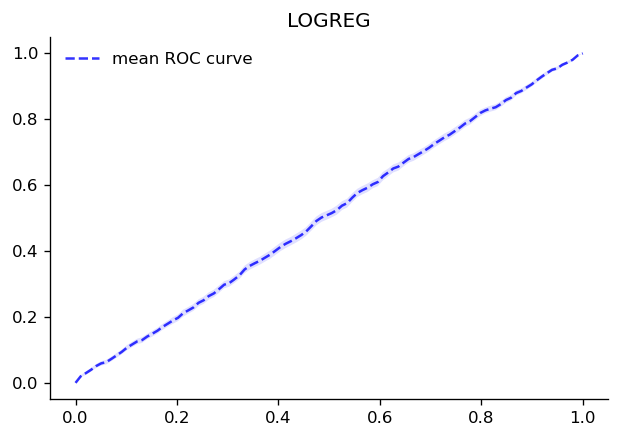

In [82]:
imbalance = 0.0001
model_name = 'logreg'
df_metrics = metrics[imbalance][model_name]['df_metrics']
f, ax = plt.subplots(dpi = 120)
plot_roc_curve(df_metrics, color = 'blue',
                ax = ax)
clean_ax(ax)
ax.set_title(model_name.upper())

Plot ROC and PR curves using plotly for animation purposes.

# Experiment 2: Changing split function (Hellinger Distance)